# Procesamiento de Lenguaje Natural

##  Clasificación de textos


In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
# Cargar datos
path = '/home/desktop/MEGA/ESPECIALIZACION/2 Semestre/NLP/Tareas/22-Abril/reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


In [3]:
data=data[['review_body', 'product_category']]

In [4]:
data

,review_body,product_category
0,"Buen. Buena calidad, y buena presentación.",jewelry
1,"Un producto a perfecto, para salir de casa con...",video_games
2,No funciona con Nintendo Switch. No hay forma ...,video_games
3,"Recomendado, los utilizo para pc y no me dan n...",video_games
4,El cable funciona bien podria ser un poco mas ...,video_games
...,...,...
995,En la foto parece que la cadena sea más gruesa...,jewelry
996,"Bien por su precio, la cadena demasiado fina.",jewelry
997,Muy bien!! Ahora tengo organizados los pendien...,jewelry
998,"Las tapas para los joystics no están nada mal,...",video_games


### Punto 1: Dividir el conjunto de datos en entrenamiento y prueba

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
print(f"Tenemos {data.shape[0]} datos en total.")
print(f"El conjunto de datos de entrenamiento (train) tiene {train.shape[0]} datos.")
print(f"El conjunto de datos de prueba (test) tiene {test.shape[0]} datos.")

Tenemos 1000 datos en total.
El conjunto de datos de entrenamiento (train) tiene 800 datos.
El conjunto de datos de prueba (test) tiene 200 datos.


###  Hacer pre-procesamiento del texto

In [7]:
stopwords_sp = stopwords.words('spanish')
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf_vect.fit(train.review_body.values);

In [8]:
X_train = tfidf_vect.transform(train.review_body.values)
y_train = train.product_category.values

X_test = tfidf_vect.transform(test.review_body.values)
y_test = test.product_category.values

print(f"Tamaño de X_train (entrenamiento): {pd.DataFrame(X_train.toarray()).shape}")
print(f"Tamaño de X_test (prueba): {pd.DataFrame(X_test.toarray()).shape}")
print(f"Tamaño de y_train {len(y_train)} y tamaño de y_test {len(y_test)}")

Tamaño de X_train (entrenamiento): (800, 3221)
Tamaño de X_test (prueba): (200, 3221)
Tamaño de y_train 800 y tamaño de y_test 200


###  Entrenar el modelo
Puedes escoger el que quieras: Regresión mediante SVM y Árbol de Decisión.

In [9]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [22]:
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

### Métricas de evaluación
Exactitud, precisión y sensibilidad

In [11]:
metricas = [precision_score, recall_score, f1_score]
print(f"Exactitud\nSVM: {accuracy_score(y_test, y_pred_svm):>4.2f}\n")
for metrica in metricas:
    print(metrica.__name__)
    print(f"SVM: {metrica(y_test, y_pred_svm, pos_label='jewelry'):.2f}")
    print()

Exactitud
SVM: 0.84

precision_score
SVM: 0.82

recall_score
SVM: 0.86

f1_score
SVM: 0.84



In [12]:
data['product_category'].value_counts()

jewelry        502
video_games    498
Name: product_category, dtype: int64

###  Matriz de confusión

In [13]:
confusion_matrix(y_test, y_pred_svm)

array([[83, 14],
       [18, 85]])

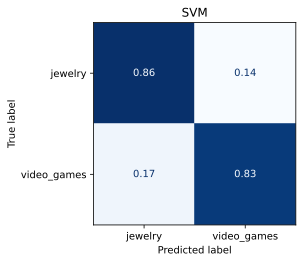

In [14]:
%config InlineBackend.figure_format = 'svg'
fig = plt.figure(figsize=(10,10))

ax3 = fig.add_subplot(2,2,3)
plot_confusion_matrix(svm, X_test, y_test, cmap = 'Blues', ax=ax3, normalize='true').im_.colorbar.remove() 
plt.title("SVM");

###  Pruebas

In [15]:
nuevos = ['collar de oro', 'incluye plata ps']
nuevos_trans = tfidf_vect.transform(nuevos)
svm.predict(nuevos_trans)

array(['jewelry', 'video_games'], dtype=object)

In [16]:
vocab = {value:key for key,value in tfidf_vect.vocabulary_.items()}


### palabras que contribuyen a la clase "jewelry"

In [17]:
[(vocab[e[0]], round(e[1],2)) for e in zip(svm.coef_[0].argsort(), sorted(svm.coef_[0]))][:10]

[('pulsera', -1.63),
 ('foto', -1.48),
 ('calidad', -1.42),
 ('gracias', -1.4),
 ('bonitos', -1.37),
 ('bonita', -1.27),
 ('cadena', -1.22),
 ('plata', -1.21),
 ('pendientes', -1.19),
 ('cierre', -1.07)]

### palabras que contribuyen a la clase "video_games"

In [18]:
[(vocab[e[0]], round(e[1],2)) for e in zip(svm.coef_[0].argsort(), sorted(svm.coef_[0]))][-10:]

[('jugar', 1.11),
 ('descripción', 1.11),
 ('consola', 1.13),
 ('ratón', 1.16),
 ('grupos', 1.23),
 ('botones', 1.31),
 ('ps', 1.34),
 ('hijo', 1.53),
 ('mando', 1.64),
 ('juego', 2.73)]

In [19]:
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train);

### Grafica árbol de descisión

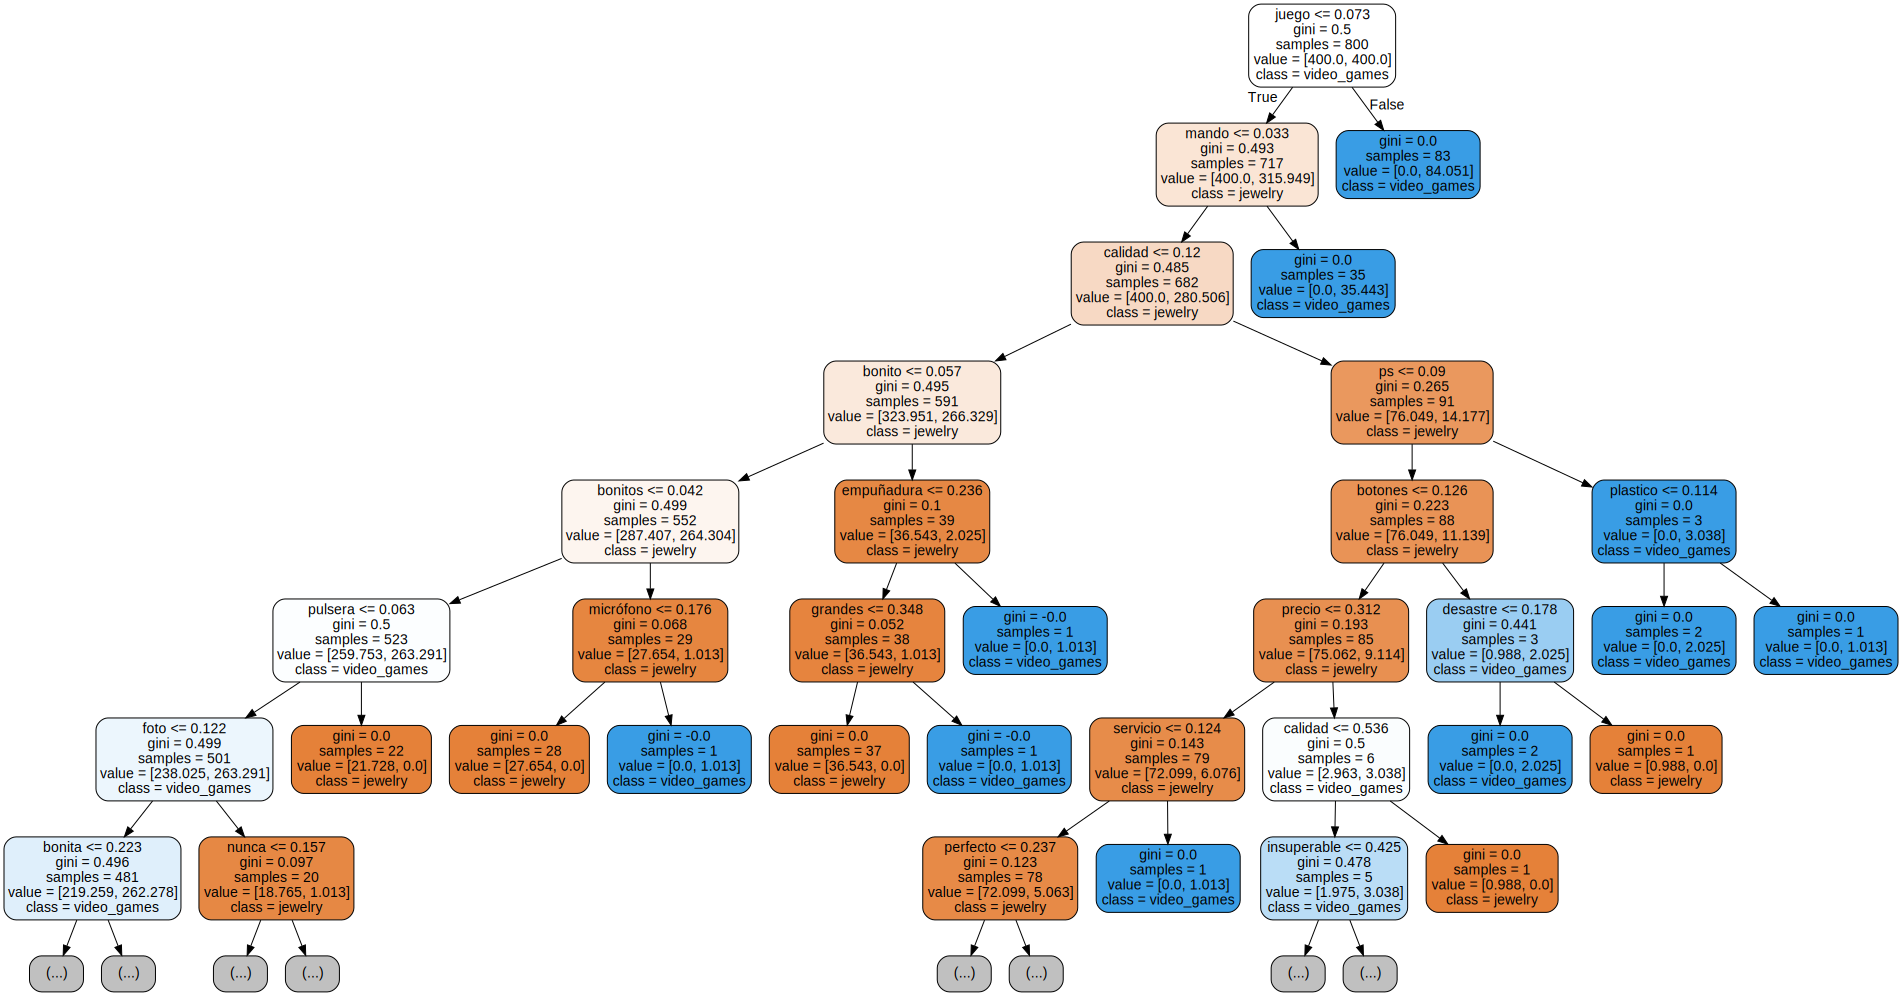

In [20]:
import graphviz 
from sklearn.tree import export_graphviz

viz = export_graphviz(dt, 
                      out_file=None, # ¿Salvar en el computador?
                      max_depth=7, # Máxima profundidad
                      feature_names=list(dict(sorted(tfidf_vect.vocabulary_.items())).keys()), # Palabras
                      class_names = ['jewelry', 'video_games'],
                      rounded=True, filled=True
                     )

graph = graphviz.Source(viz)
graph

### Interpretación

- Se puede considerar un modelo bastante bueno debido a que sus métricas estan por encima del 80%, y en las pruebas con valores nuevos es bastante acertado al precedir las categorias